# "Classifiez automatiquement des biens de consommation"
_NLP Cleaning Notebook_

In [1]:
import pandas as pd
df = pd.DataFrame()
for i in range (10):
    df['r'+str(i)] = ['u']*20

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [2]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on Colab

In [3]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Mounted at /gdrive
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [4]:
import os
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
    os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')

In [5]:
# import os
# if is_colab==True:
#     if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
#         os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')
# else:
#     if not (os.path.exists(os.getcwd()+'/requirements_pict.txt') \
#                      and os.path.exists(os.getcwd()+'/P6_functions.py')):
#         print("ERROR: Make sure 'P6_functions.py' and \
# 'requirements_pict.txt' are in the current working directory")

In [6]:
!pip install -r requirements_pict.txt

     |████████████████████████████████| 276kB 10.1MB/s 
     |████████████████████████████████| 143kB 22.1MB/s 
     |████████████████████████████████| 30.6MB 126kB/s 
     |████████████████████████████████| 25.0MB 1.5MB/s 
     |████████████████████████████████| 1.1MB 53.5MB/s 
  Created wheel for gTTS-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4096 sha256=7a7522284775db254cce4f6eafd59689f283ed4b0c7db6f9a6ef8ce82b23413a
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
  Created wheel for marisa-trie: filename=marisa_trie-0.7.5-cp36-cp36m-linux_x86_64.whl size=861294 sha256=404ca9c789d4fdecc2706de8176c675c422f3a012f5e1b26a8a45db11f059ed7
  Stored in directory: /root/.cache/pip/wheels/45/24/79/022624fc914f0e559fe8a1141aaff1f9df810905a13fc75d57
  Created wheel for mwparserfromhell: filename=mwparserfromhell-0.5.4-cp36-cp36m-linux_x86_64.whl size=183778 sha256=fa98c95a7f3c46c757cf5e9e75632243fce22d98c663af94dc18eef6c8c

In [7]:
from P6_functions import *

Installations (creating the requirements file)

In [8]:
# !pip install gtts
# !pip install wikipedia2vec==0.2.2

# !pip install opencv-python==3.4.2.17
# !pip install opencv-contrib-python==3.4.2.17

In [9]:
# !pip freeze > requirements_pict.txt

Importation of modules and packages. 

In [10]:
import io

import string

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
import PIL

# import warnings
# warnings.filterwarnings('ignore')

Setting pandas display options.

In [11]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [12]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [13]:
speak('Packages and modules successfully imported')

### 0.1 Importing the datasets

Data is composed of 9 distinct .csv files we'll load in a dictionnary of dataframes.

In [14]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df = pd.read_csv("../DATA/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


In [15]:
# speak('Datasets successfully imported')

### 0.2 Categories

In [16]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

# determining the maximum tree depth of categories
ser_depth = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df.index)

In [17]:
# Create a dataframe for images

df_image = df[['product_name', 'description']].copy('deep')
df_image['category'] = \
    df_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                         'Baby Care': 'Baby', 
                                         'Watches': 'Watches',
                                         'Home Decor & Festive Needs': 'Decor',
                                         'Kitchen & Dining': 'Kitchen',
                                         'Beauty and Personal Care': 'Beauty',
                                         'Computers': 'Computers'})
indexes = df_image.index

### 0.3 Images properties

In [18]:
from PIL import Image

### 0.4 Browsing images

In [19]:
# !pip install easyimages

In [20]:
# from easyimages import EasyImageList
# Li = EasyImageList.from_folder("../DATA/Images")
# Li.symlink_images()
# Li.html(sample=10, size=44)

## 1 Image pre-processing

### 1.0 Vectorization, resizing, adjusting contrast of images

Load each image, resizes to 224*224 and store the values of pixel in HSV in the dataframe

In [21]:
# from PIL import Image, ImageOps

# # to silence the decompression bomb warning
# Image.MAX_IMAGE_PIXELS = 1000000000        
# import colorsys

# rgb_to_hsv = np.vectorize(colorsys.rgb_to_hsv)

# size = 224

# # df_temp = pd.DataFrame([])
# dict_images = {}
# li_cols = [ l+'_'+str(i) for l in ['H', 'S', 'V']\
#            for i in range(size*size)]

# for i, ind in enumerate(indexes):
#     img = np.array(Image.open("../DATA/Images/"+ind+".jpg"))
#     img = preproc_image(img, size=224, fill_col=(255,255,255),
#                         autocontrast = True, equalize=False,
#                         gauss_blur=3, interpolation=Image.ANTIALIAS)
#     dict_images[ind] = img
#     # img_ravel = np.stack(np.array(rgb_to_hsv(img[:,:,0],
#     #                                          img[:,:,1],
#     #                                          img[:,:,2])), 0).ravel()
#     # ser = pd.Series(img_ravel, index = li_cols, name=ind).to_frame()
#     # df_temp = pd.concat([df_temp, ser.T], axis=0)

# # df_image = pd.concat([df_image, df_temp], axis=1)

In [22]:
# import dill
# dill.dump(dict_images, open('dict_images.pkl', mode='wb'))

In [23]:
import dill
df_image = dill.load(open('df_image.pkl', mode='rb'))
dict_images = dill.load(open('dict_images.pkl', mode='rb'))

Visualisation séparée des trois canaux (Hue, Saturation, Value)

In [24]:
# fig = plt.figure(figsize=(10,4))
# li_n = []
# for im, color, title, i in zip([img_h, img_s, img_v],
#                                 ['red', 'blue', 'black'],
#                                 ['Hue', 'Saturation', 'Value'],
#                                 range(1,4)):
#     ax1 = fig.add_subplot(2,3,i)
#     ax1.imshow(im, cmap='Greys')
#     ax1.set(xlim=(0,255))
#     ax1.set_title(title, fontweight='bold')
#     ax2 = fig.add_subplot(2,3,i+3)
#     n, bins, patches = ax2.hist(im.flatten(), color=color, bins=range(256))
#     li_n.append(n)
# plt.tight_layout(rect=[0,0,1,0.92])
# plt.show()

# 2 Clustering

In [25]:
df_res_clust = pd.DataFrame()
df_res_clust['category'] = df_image['category']

## Clustering on whole resized HSV images (pixels)

In [26]:
# Data selection to train clusterer (HSV 224x224 pixels)
X_df = df_image.iloc[:,3:]
print("Size of the training data :", X_df.shape)

Size of the training data : (1050, 150528)


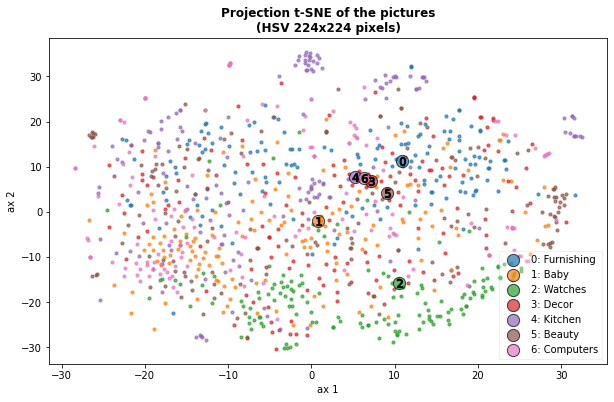

In [27]:
# Visualization of the images (HSV 224 x 224 pixels) on a t-SNE projection

ser_categories = pd.Series(df_image['category'].values, 
                           index=df_image.index,
                           name='Clust')

plot_projection(X_df, model=None, ser_clust=ser_categories,
                proj='t-SNE', size=10, legend_on=True,
                title="Projection t-SNE of the pictures\n(HSV 224x224 pixels)",
                figsize=(10, 6), palette='tab10',
                fig=None, ax=None, random_state=14)

In [28]:
# Create the model
from sklearn.cluster import KMeans
k=7 # number of categories
km = KMeans(n_clusters=k) 

In [29]:
# Fitting the Kmeans model
km.fit(X_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
# Appending the best results of the Kmeans clustering
df_res_clust['KMclust_HSVpx'] = km.labels_

In [31]:
df_res_clust.sample(5)

,category,KMclust_HSVpx
19d2dbc1789653c58bce08c169662cf2,Computers,2
8a306758531cffad41e7a28e41576c49,Decor,0
f69bef5db54cb4c83b2aa8d0ce829d4e,Kitchen,5
f3dec6a97225941bf9c3213e73943bd3,Furnishing,2
0ddc40c08d9a9bafc4d14eddd98db7c0,Kitchen,0


## Clustering on a bag of visual words (SIFT)

In [32]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

### Extracts local features from images using SIFT

The below function returns an array whose first index holds a list that holds all local features from all images without an order. This is our visual dictionary. And the second index holds the sift vectors dictionary which holds the descriptors but this is separated class by class

In [33]:
# Creates descriptors using sift 
# Takes one parameter that is images dictionary
# Return an array whose first index holds the decriptor_list without an order
# And the second index holds the sift_vectors dictionary which holds
# the descriptors but this is seperated class by class

def sift_features(images):
    dict_sift_descriptors, dict_keypoints = {}, {}
    all_descriptors_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,img in images.items():
        features = []
        kp, des = sift.detectAndCompute(img,None)
        all_descriptors_list.extend(des)
        dict_sift_descriptors[key] = des
        dict_keypoints[key] = kp
    return dict_keypoints, dict_sift_descriptors, all_descriptors_list

# def get_descriptors(image_path):
#     # load image and convert it to grayscale
#     img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     # detect key points and descriptors
#     keypoints, descriptors = model.detectAndCompute(img_gray, None)
#     # returns keypoints and descriptors
#     return keypoints, descriptors

In [34]:
# # Store descriptors and bovw features 
# # keypoints_list, descriptor_list, all_bovw_feature = sift_features(dict_images) 
# dict_keypoints, dict_sift_descriptors, all_descriptors_list = \
#                                              sift_features(dict_images) 

In [35]:
# import dill
# dill.dump((dict_sift_descriptors, all_descriptors_list),
#           open("descriptors.pkl", "wb"))

In [36]:
import dill
dict_sift_descriptors, all_descriptors_list  = \
    dill.load(open("descriptors.pkl", "rb"))

In [37]:
# print("list of the keypoints", len(keypoints_list))
print("list of all the descriptors: ", len(all_descriptors_list))
print("dictionnary giving all the descriptors (vectors) for each image: ",
      len(dict_sift_descriptors.keys()))

list of all the descriptors:  230755
dictionnary giving all the descriptors (vectors) for each image:  1050


### Selects the visual words

Send the visual dictionary to the k-means clustering algorithm and find the visual words which are center points.

In [38]:
# A k-means clustering algorithm who takes 2 parameter which is number 
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.

from sklearn.cluster import KMeans

def descriptors_cluster_centers(k, descriptors_list):
    clusterer = KMeans(n_clusters = k, n_init=10)
    clusterer.fit(descriptors_list)
    visual_words = clusterer.cluster_centers_ 
    return visual_words, clusterer

In [39]:
# # Takes the central points which is visual words   

# visual_words, desc_clusterer = descriptors_cluster_centers(150,
#                                                            all_descriptors_list)
# visual_words.shape

In [40]:
# import dill
# dill.dump((visual_words, desc_clusterer), open("visual_words.pkl", "wb"))

In [41]:
import dill
visual_words, desc_clusterer = dill.load(open("visual_words.pkl", "rb"))

In [42]:
# détermine pour chaque image a quel cluster appartient les descripteurs
# renvoie un dictionnaire avec la liste des numéros des clusters parmi 150
# convertit le dictionnaire en pd.Series, puis en dataframe (multilabelbinarizer)
vw_list = []
ind_img_list = []
for n_img, desc_list in dict_sift_descriptors.items():
    vwords = desc_clusterer.predict(desc_list) # liste des numéros des visuals words de l'image
    vw_list.append(vwords) # liste des listes de vw pour toutes les images
    ind_img_list.append(n_img) # liste des indexes des images

In [43]:
from collections import Counter
df_visual_words = pd.DataFrame([Counter(x) for x in vw_list],
                               index = ind_img_list).fillna(0)
df_visual_words = df_visual_words[sorted(df_visual_words.columns)]

In [ ]:
df_visual_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
55b85ea15a1536d46b7190ad6fff8ce7,2.00,1.00,22.00,3.00,4.00,12.00,0.00,0.00,13.00,0.00,2.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,3.00,4.00,16.00,1.00,1.00,1.00,2.00,0.00,5.00,5.00,12.00,1.00,4.00,0.00,2.00,2.00,3.00,10.00,1.00,0.00,9.00,0.00,...,1.00,1.00,2.00,0.00,2.00,0.00,1.00,2.00,0.00,0.00,0.00,2.00,0.00,0.00,5.00,1.00,4.00,3.00,1.00,0.00,0.00,4.00,3.00,1.00,2.00,1.00,5.00,1.00,2.00,3.00,0.00,2.00,0.00,4.00,5.00,1.00,0.00,2.00,0.00,1.00
7b72c92c2f6c40268628ec5f14c6d590,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2.00,0.00,2.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,...,2.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,18.00,1.00,0.00,0.00,0.00,0.00,30.00,0.00,0.00,0.00,13.00,0.00,0.00,0.00
64d5d4a258243731dc7bbb1eef49ad74,2.00,0.00,3.00,1.00,2.00,12.00,0.00,55.00,15.00,10.00,1.00,1.00,7.00,2.00,1.00,1.00,1.00,0.00,2.00,0.00,32.00,0.00,7.00,4.00,1.00,1.00,3.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,3.00,3.00,12.00,0.00,8.00,2.00,...,3.00,0.00,1.00,2.00,0.00,1.00,4.00,1.00,0.00,0.00,2.00,8.00,5.00,0.00,1.00,0.00,9.00,0.00,7.00,0.00,2.00,10.00,8.00,2.00,1.00,0.00,2.00,3.00,0.00,0.00,0.00,5.00,4.00,0.00,2.00,0.00,13.00,0.00,0.00,1.00
d4684dcdc759dd9cdf41504698d737d8,1.00,1.00,2.00,2.00,0.00,0.00,2.00,0.00,0.00,0.00,7.00,0.00,0.00,0.00,1.00,7.00,3.00,0.00,3.00,0.00,0.00,0.00,1.00,2.00,1.00,2.00,0.00,1.00,2.00,0.00,0.00,4.00,7.00,2.00,1.00,0.00,1.00,0.00,3.00,1.00,...,0.00,3.00,6.00,1.00,3.00,8.00,4.00,1.00,4.00,2.00,2.00,0.00,2.00,7.00,0.00,5.00,3.00,7.00,0.00,1.00,5.00,0.00,1.00,2.00,0.00,3.00,2.00,1.00,10.00,1.00,2.00,0.00,0.00,2.00,1.00,14.00,5.00,3.00,0.00,2.00
6325b6870c54cd47be6ebfbffa620ec7,0.00,0.00,0.00,2.00,1.00,0.00,3.00,0.00,1.00,0.00,0.00,1.00,1.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,3.00,4.00,2.00,2.00,5.00,3.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,2.00,0.00,2.00,4.00,...,1.00,3.00,1.00,2.00,1.00,9.00,3.00,1.00,1.00,2.00,2.00,1.00,3.00,0.00,2.00,0.00,2.00,1.00,2.00,0.00,0.00,1.00,1.00,0.00,4.00,1.00,0.00,0.00,1.00,3.00,1.00,2.00,0.00,0.00,5.00,0.00,2.00,0.00,41.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,1.00,4.00,2.00,2.00,3.00,0.00,0.00,2.00,0.00,7.00,1.00,1.00,6.00,0.00,3.00,2.00,3.00,3.00,0.00,7.00,0.00,1.00,1.00,7.00,2.00,3.00,5.00,2.00,0.00,8.00,11.00,2.00,1.00,3.00,1.00,0.00,1.00,7.00,2.00,0.00,...,2.00,2.00,0.00,8.00,0.00,1.00,2.00,1.00,3.00,1.00,0.00,2.00,5.00,0.00,3.00,0.00,3.00,0.00,0.00,2.00,0.00,1.00,2.00,1.00,2.00,2.00,1.00,3.00,1.00,5.00,3.00,2.00,1.00,2.00,6.00,0.00,13.00,0.00,5.00,4.00
fd6cbcc22efb6b761bd564c28928483c,1.00,6.00,0.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,3.00,2.00,2.00,0.00,3.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,3.00,0.00,0.00,4.00,1.00,0.00,1.00,2.00,2.00,0.00,0.00,2.00,0.00,1.00,...,2.00,0.00,0.00,0.00,0.00,2.00,0.00,1.00,1.00,1.00,2.00,0.00,2.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,2.00,0.00,4.00,2.00,1.00,2.00,2.00,1.00,1.00,1.00,3.00,1.00,3.00,1.00,0.00,1.00,0.00,2.00,0.00
5912e037d12774bb73a2048f35a00009,4.00,11.00,2.00,1.00,1.00,5.00,1.00,5.00,4.00,2.00,3.00,6.00,1.00,7.00,3.00,1.00,4.00,2.00,1.00,1.00,0.00,2.00,0.00,8.00,1.00,2.00,0.00,0.00,0.00,2.00,9.00,1.00,1.00,4.00,0.00,1.00,1.00,6.00,1.00,2.00,...,5.00,4.00,6.00,5.00,1.00,6.00,0.00,2.00,2.00,8.00,3.00,2.00,4.00,0.00,6.00,3.0

### KMeans clustering on the BoVW

In [ ]:
# Data selection to train clusterer (HSV 224x224 pixels)
X_df = df_visual_words
print("Size of the training data :", X_df.shape)

Size of the training data : (1050, 150)


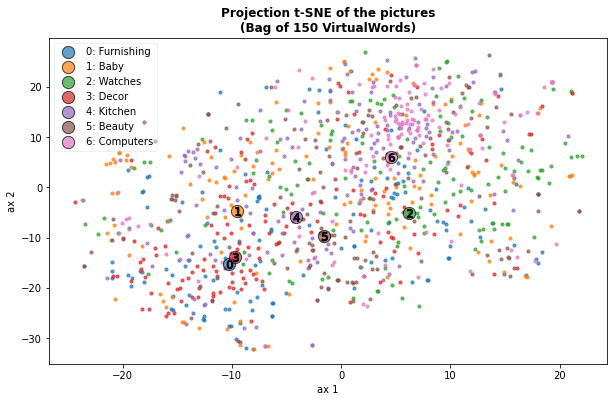

In [ ]:
# Visualization of the images (BoVW of 150 VW) on a t-SNE projection

ser_categories = pd.Series(df_image['category'].values, 
                           index=df_image.index,
                           name='Clust')

plot_projection(X_df, model=None, ser_clust=ser_categories,
                proj='t-SNE', size=10, legend_on=True,
                title="Projection t-SNE of the pictures\n(Bag of 150 VirtualWords)",
                figsize=(10, 6), palette='tab10',
                fig=None, ax=None, random_state=14)

In [ ]:
# Create the model
from sklearn.cluster import KMeans
k=7 # number of categories
km = KMeans(n_clusters=k) 

In [ ]:
# Fitting the Kmeans model
km.fit(X_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# Appending the best results of the Kmeans clustering
df_res_clust['KMclust_Bo150VW'] = km.labels_

In [ ]:
df_res_clust.sample(5)

,category,KMclust_HSVpx,KMclust_Bo150VW
7b1c5edc85bc7e31edf49ab70034bb3a,Beauty,5,1
9d3ca83f7017d6e9e129964e88503ff0,Baby,3,1
906b5b16c78ba1c718501138702cb32c,Decor,4,5
19d2dbc1789653c58bce08c169662cf2,Computers,0,1
2c475daafe597ed93c1e27fcaa38d8cc,Computers,4,1


## Feature extraction par transfer learning sur réseau préentrainé

## Comparison of clusters labels with true categories

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
df_res_clust.columns

Index(['category', 'KMclust_HSVpx', 'KMclust_Bo150VW'], dtype='object')

In [ ]:
ser_ari_pairs_models = ARI_column_pairs(df_res_clust, first_vs_others=True,
                                        print_opt=True)

--- ARI between first and the 2 others ---
ARI: mean=0.042, std=0.011, min=0.031, max=0.054 


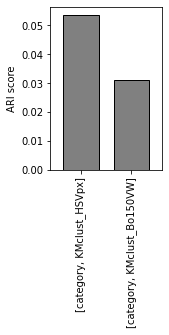

In [ ]:
fig = plt.figure(figsize=(2,3))
ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
plt.ylabel('ARI score')
# plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# plt.gca().set(ylim=(0.85,1))
plt.show()

# Exportation

Now we export the dataset of aggregated orders in a .csv file.